<a href="https://colab.research.google.com/github/ajay-sainy/notebooks/blob/main/Tacotron_Synthesizer_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==1.15
!pip install gdown
!pip install -q librosa unidecode
!pip install tqdm -q
import gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 412.3 MB 26 kB/s 
     |████████████████████████████████| 50 kB 8.3 MB/s 
     |████████████████████████████████| 3.8 MB 48.3 MB/s 
     |████████████████████████████████| 503 kB 70.5 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=083ff6eecaf56791749fa2c5268a814f1707fb53db45f54800e0664def91d059
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting un

In [2]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


Current Config:
pronounciation_dictionary: False
show_graphs: True
max_duration (in seconds): 25
stop_threshold: 0.324


Enter/Paste your text.
--------------------------------------------------
evolutionary biologist but I would say more the psychologists like to be in


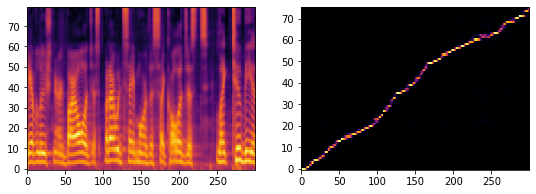

--------------------------------------------------
I will probably do a separate video on that with links.


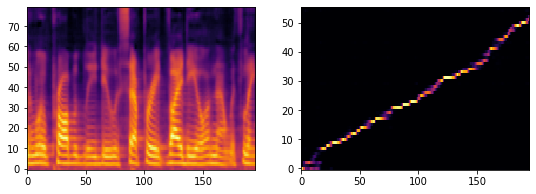

--------------------------------------------------
GitHub, Inc., is an Internet hosting service for software development and version control using Git. It provides the distributed version control of Git plus access control, bug tracking, software feature requests, task management, continuous integration, and wikis for every project


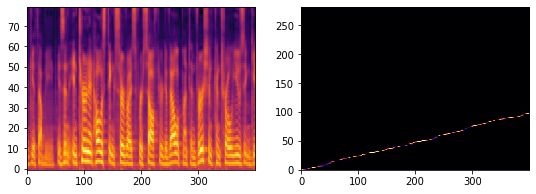

--------------------------------------------------
It provides the distributed version control of Git plus access control, bug tracking, software feature requests, task management, continuous integration, and wikis for every project


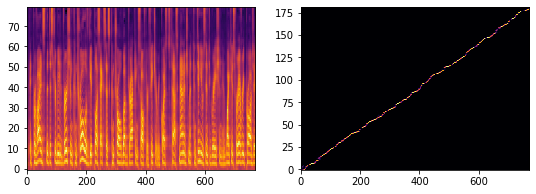

--------------------------------------------------
That covers all up-to-date versions of open source software


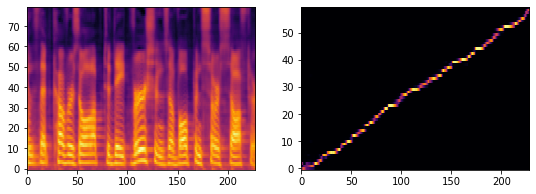

--------------------------------------------------


In [ ]:
#@title Tacotron2 and HiFi-GAN Inference Notebook { display-mode: "form" }

#@markdown ---

#@markdown Just put your model code in the section that says "Tacotron_model", and press the play button.

#@markdown ---

#@markdown Contributors (that I stole the notebook from):
#@markdown - Cookie
#@markdown - Synthbot (Data preprocessing)
#@markdown - Flutteranon (Original Synthesis notebook that I stole)
#@markdown - Clipper (doing some other MLP stuff)
#@markdown - SortAnon (adding HiFi-GAN)
#@markdown - Some other people probably

#@markdown ---
#@markdown Config:

#@markdown Restart the code to apply any changes.

#Add new characters here.
#Universal HiFi-GAN (has some robotic noise): 1qpgI41wNXFcH-iKq1Y42JlBC9j0je8PW
Tacotron_model = "1BuI2-iijj639ZEYsT8bcKzSqbHB40yzN" #@param {type:"string"}

TACOTRON2_ID = Tacotron_model
HIFIGAN_ID = "1qpgI41wNXFcH-iKq1Y42JlBC9j0je8PW"

# Check if Initilized
try:
    initilized
except NameError:
    print("Setting up, please wait.\n")
    from tqdm.notebook import tqdm
    with tqdm(total=5, leave=False) as pbar:
        import os
        from os.path import exists, join, basename, splitext
        git_repo_url = 'https://github.com/NVIDIA/tacotron2.git'
        project_name = splitext(basename(git_repo_url))[0]
        if not exists(project_name):
            # clone and install
            !git clone -q --recursive {git_repo_url}
            !git clone -q --recursive https://github.com/SortAnon/hifi-gan
        pbar.update(1) # downloaded TT2 and HiFi-GAN
        import sys
        sys.path.append('hifi-gan')
        sys.path.append(project_name)
        import time
        import matplotlib
        import matplotlib.pylab as plt
        d = 'https://drive.google.com/uc?id='

        %matplotlib inline
        import IPython.display as ipd
        import numpy as np
        import torch
        import json
        from hparams import create_hparams
        from model import Tacotron2
        from layers import TacotronSTFT
        from audio_processing import griffin_lim
        from text import text_to_sequence
        from env import AttrDict
        from meldataset import MAX_WAV_VALUE
        from models import Generator

        pbar.update(1) # initialized Dependancies

        graph_width = 900
        graph_height = 360
        def plot_data(data, figsize=(int(graph_width/100), int(graph_height/100))):
            %matplotlib inline
            fig, axes = plt.subplots(1, len(data), figsize=figsize)
            for i in range(len(data)):
                axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                            interpolation='none', cmap='inferno')
            fig.canvas.draw()
            plt.show()

        # Setup Pronounciation Dictionary
        !gdown "https://github.com/justinjohn0306/tacotron2/releases/download/assets/merged.dict.txt"
        thisdict = {}
        for line in reversed((open('merged.dict.txt', "r").read()).splitlines()):
            thisdict[(line.split(" ",1))[0]] = (line.split(" ",1))[1].strip()

        pbar.update(1) # Downloaded and Set up Pronounciation Dictionary

        def ARPA(text, punctuation=r"!?,.;", EOS_Token=True):
            out = ''
            for word_ in text.split(" "):
                word=word_; end_chars = ''
                while any(elem in word for elem in punctuation) and len(word) > 1:
                    if word[-1] in punctuation: end_chars = word[-1] + end_chars; word = word[:-1]
                    else: break
                try:
                    word_arpa = thisdict[word.upper()]
                    word = "{" + str(word_arpa) + "}"
                except KeyError: pass
                out = (out + " " + word + end_chars).strip()
            if EOS_Token and out[-1] != ";": out += ";"
            return out

        def get_hifigan(MODEL_ID):
            # Download HiFi-GAN
            hifigan_pretrained_model = 'hifimodel'
            gdown.download(d+MODEL_ID, hifigan_pretrained_model, quiet=False)
            if not exists(hifigan_pretrained_model):
                raise Exception("HiFI-GAN model failed to download!")

            # Load HiFi-GAN
            conf = os.path.join("hifi-gan", "config_v1.json")
            with open(conf) as f:
                json_config = json.loads(f.read())
            h = AttrDict(json_config)
            torch.manual_seed(h.seed)
            hifigan = Generator(h).to(torch.device("cuda"))
            state_dict_g = torch.load(hifigan_pretrained_model, map_location=torch.device("cuda"))
            hifigan.load_state_dict(state_dict_g["generator"])
            hifigan.eval()
            hifigan.remove_weight_norm()
            return hifigan, h

        hifigan, h = get_hifigan(HIFIGAN_ID)
        pbar.update(1) # Downloaded and Set up HiFi-GAN

        def has_MMI(STATE_DICT):
            return any(True for x in STATE_DICT.keys() if "mi." in x)

        def get_Tactron2(MODEL_ID):
            # Download Tacotron2
            tacotron2_pretrained_model = 'MLPTTS'
            gdown.download(d+MODEL_ID, tacotron2_pretrained_model, quiet=False)
            if not exists(tacotron2_pretrained_model):
                raise Exception("Tacotron2 model failed to download!")
            # Load Tacotron2 and Config
            hparams = create_hparams()
            hparams.sampling_rate = 22050
            hparams.max_decoder_steps = 3000 # Max Duration
            hparams.gate_threshold = 0.25 # Model must be 25% sure the clip is over before ending generation
            model = Tacotron2(hparams)
            state_dict = torch.load(tacotron2_pretrained_model)['state_dict']
            if has_MMI(state_dict):
                raise Exception("ERROR: This notebook does not currently support MMI models.")
            model.load_state_dict(state_dict)
            _ = model.cuda().eval().half()
            return model, hparams

        model, hparams = get_Tactron2(TACOTRON2_ID)
        previous_tt2_id = TACOTRON2_ID

        pbar.update(1) # Downloaded and Set up Tacotron2

        # Extra Info
        def end_to_end_infer(text, pronounciation_dictionary, show_graphs):
            for i in [x for x in text.split("\n") if len(x)]:
                if not pronounciation_dictionary:
                    if i[-1] != ";": i=i+";" 
                else: i = ARPA(i)
                with torch.no_grad(): # save VRAM by not including gradients
                    sequence = np.array(text_to_sequence(i, ['english_cleaners']))[None, :]
                    sequence = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long()
                    mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
                    if show_graphs:
                        plot_data((mel_outputs_postnet.float().data.cpu().numpy()[0],
                                alignments.float().data.cpu().numpy()[0].T))
                    y_g_hat = hifigan(mel_outputs_postnet.float())
                    audio = y_g_hat.squeeze()
                    audio = audio * MAX_WAV_VALUE
                    print("")
                    ipd.display(ipd.Audio(audio.cpu().numpy().astype("int16"), rate=hparams.sampling_rate))
    from IPython.display import clear_output
    clear_output()
    initilized = "Ready"

if previous_tt2_id != TACOTRON2_ID:
    print("Updating Models")
    model, hparams = get_Tactron2(TACOTRON2_ID)
    hifigan, h = get_hifigan(HIFIGAN_ID)
    previous_tt2_id = TACOTRON2_ID

pronounciation_dictionary = False #@param {type:"boolean"}
# disables automatic ARPAbet conversion, useful for inputting your own ARPAbet pronounciations or just for testing
show_graphs = True #@param {type:"boolean"}
max_duration = 25 #this does nothing
model.decoder.max_decoder_steps = 1000 #@param {type:"integer"}
stop_threshold = 0.324 #@param {type:"number"}
model.decoder.gate_threshold = stop_threshold

#@markdown ---

print(f"Current Config:\npronounciation_dictionary: {pronounciation_dictionary}\nshow_graphs: {show_graphs}\nmax_duration (in seconds): {max_duration}\nstop_threshold: {stop_threshold}\n\n")

time.sleep(1)
print("Enter/Paste your text.")
contents = []
while True:
    try:
        print("-"*50)
        line = input()
        if line == "":
            continue
        end_to_end_infer(line, pronounciation_dictionary, show_graphs)
    except EOFError:
        break
    except KeyboardInterrupt:
        print("Stopping...")
        break